In [1]:
from importlib import reload  
import numpy as np
import matplotlib.pyplot as plt
import pycraf
import cysgp4
import astropy.coordinates as coord
from pycraf import conversions as cnv
from pycraf import protection, antenna, geometry,satellite
from astropy import units as u, constants as const
import glob
from scepter import skynet,obs,tlefinder
from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u

from astropy.coordinates import AltAz, ICRS
from matplotlib.gridspec import GridSpec
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [2]:

###reload here
reload(skynet)
reload(obs)
longitude = coord.Angle("11d55m11s").deg
latitude = coord.Angle("+57d23m37s").deg
elevation = 16 * u.m


loc1 = EarthLocation(longitude, latitude, elevation)
ant1=cysgp4.PyObserver(longitude,latitude,elevation.to(u.km).value)

# baseline=75 *u.m### m
longitude = coord.Angle("11d55m15s").deg
latitude = coord.Angle("+57d23m20s").deg
elevation = 16 * u.m
ant2=cysgp4.PyObserver(longitude,latitude,elevation.to(u.km).value)
loc2 = EarthLocation(longitude, latitude, elevation)

longitude = coord.Angle("11d40m08s").deg
latitude = coord.Angle("+57d30m20s").deg
elevation = 50 * u.m
ant3=cysgp4.PyObserver(longitude,latitude,elevation.to(u.km).value)
loc3 = EarthLocation(longitude, latitude, elevation)

observers = np.array([ant1,ant2,ant3])

# x1,y1,z1 = pycraf.geospatial.wgs84_to_itrf2008(ant1.loc.lon*u.deg, ant1.loc.lat*u.deg, ant1.loc.alt*u.m)
# print(x1.value,y1,z1)

In [3]:
bearings,baselines = obs.baseline_pairs(observers)

for i in range(len(observers)):
    print(bearings[i],(baselines[i]))


###load the TLEs

[0. 0. 0.] 0.0
[ 419.64819316  156.8758647  -283.40671509] 530.1264086074316
[ -7208.65330539 -16889.39096622   6707.80094833] 19550.212358167264


### set up time and sky grid

In [4]:
niters = 1
pydt = cysgp4.PyDateTime() ## take current date and time
start_times_window = 24 * u.hour
time_range, time_resol = 100*u.s, 1e-1*u.s  # seconds
epochiters=time_range/time_resol

# print(start_times,td)
mjds = skynet.plantime(niters,start_times_window,time_range,time_resol,pydt)
print(mjds.shape)

(1, 1, 1, 1, 1000, 1)


In [5]:
min_elevation = 30* u.deg
grid_size = 1 * u.deg
npoints=1 ##pointing per cell
skygrid = skynet.pointgen(niters=npoints,
    step_size=grid_size,
    lat_range=(44*u.deg ,46 * u.deg),
    lon_range=(140*u.deg,150*u.deg),
    rnd_seed=0,
    )
print(skygrid[2]["cell_lon_high"].shape)

#### a typical transmitter model, needed to setup 
tx=obs.transmitter_info(p_tx_carrier=-44 * cnv.dBm, carrier_bandwidth=250*u.MHz, duty_cycle=100 * u.percent, d_tx=1*u.m,freq=10.95*u.GHz)
p_tx=tx.power_tx(10.7*u.GHz)
print(p_tx)


(14,)
-27.68556230986828 dB(mW)


In [6]:
##load some tle from starlink
import requests
url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=oneweb&FORMAT=tle'
ctrak_oneweb = requests.get(url).text

tle_list = cysgp4.tle_tuples_from_text(ctrak_oneweb)

In [7]:
tles = np.array([
    cysgp4.PyTle(*tle) for tle in tle_list
    ])  # use which TLEs
# tles=np.random.choice(a=tles,size=1000)
print (f'we are simulating {tles.shape[0]} satellites over {niters*start_times_window.to_value(u.day)} days,')
print(f'each day/epoch contains {epochiters} integrations over {time_range} seconds')
print(tles.shape)

we are simulating 651 satellites over 1.0 days,
each day/epoch contains 1000.0 integrations over 100.0 s seconds
(651,)


In [8]:
dish=13.2*u.m
eta=0.7 *100*u.percent ## in percentage
### frequency band
## transmitter parameters
sat_antenna=0.1*u.m
### observatory list will be passed on internally like this

rx=obs.receiver_info(dish,eta,observers,freq=10.7*u.GHz,bandwidth=2*u.GHz)

1.2589254117941673 W / (Hz m2)


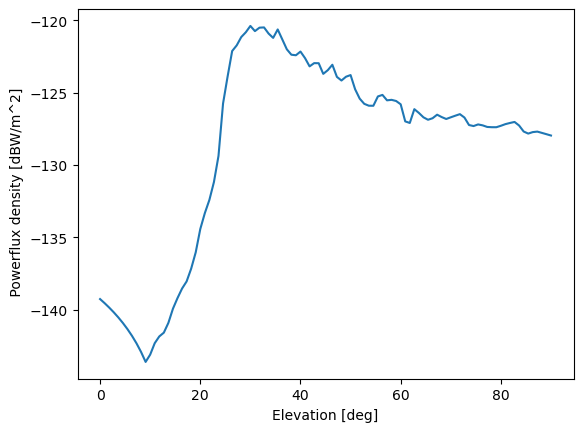

In [9]:
el_response=pd.read_csv('starlink_statistical_pfd.csv')
x_el=el_response['el'].values
y_spfd=el_response['psd_dBW_m2_4khz'].values  ### spectral powerflux density

scale4khz=50e6/4e3 ###4kHz to 1 Hz 
print((1*cnv.dB_W_m2_Hz).to(u.W/u.m**2/u.Hz))
###powerflux_nu = powerflux / bandwidth

y_pfd=(y_spfd*cnv.dB_W_m2_Hz).to(u.W/u.m**2/u.Hz)*(scale4khz*u.Hz) ### powerflux density I think in dB units it's this log factor, maybe should change this methiod
y_pfd=y_pfd.to(cnv.dB_W_m2)
plt.plot(x_el,y_pfd)
plt.ylabel(' Powerflux density [dBW/m^2]')
plt.xlabel('Elevation [deg]')
plt.show()

### array order is observer, pointing per grid, skygrid cells, epochs, time samples per epoch, number of satellites

In [10]:
test=obs.obs_sim(tx,rx,skygrid,mjds)
print(test.location)
print(test.grid_az.shape)

[[[[[[<PyObserver: 11.9197d, 57.3936d, 0.0160km>]]]]]




 [[[[[<PyObserver: 11.9208d, 57.3889d, 0.0160km>]]]]]




 [[[[[<PyObserver: 11.6689d, 57.5056d, 0.0500km>]]]]]]
(1, 1, 14, 1, 1, 1)


In [11]:
## if first time run the populate function to create coordinates
# test.populate(tles,save=True,savename='oneweb_1ms.npz')  

test.load_propagation(nparray="oneweb_1ms.npz")
### cut the whole array using the same method
test.reduce_sats(el_limit=10)
nsat=0
print('check array shapes below')
print('sat_frame az',test.satf_az.shape)
print('sat_frame el',test.satf_el.shape)

check array shapes below
sat_frame az (3, 1, 1, 1, 1000, 32)
sat_frame el (3, 1, 1, 1, 1000, 32)


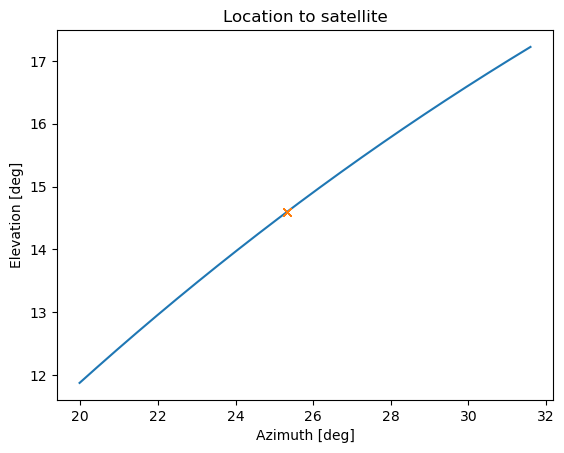

In [12]:
### get one satellite

sat_dist=test.satf_dist[:,:,:,:,:,nsat]
time_1d = Time(mjds.flatten(), format='mjd')

#### setting up the altaz frame for the antennas
#### also get the 1-d arrays of the satellite location in altaz frame
sat_az=test.topo_pos_az[0,:,:,:,:,nsat].flatten()
sat_el=test.topo_pos_el[0,:,:,:,:,nsat].flatten()

altaz=AltAz(obstime=time_1d,location=loc1)
sat_coord=SkyCoord(sat_az*u.deg,sat_el*u.deg,frame=altaz)
idx_t=len(time_1d)//2
pnt=sat_coord[idx_t].transform_to('icrs')
ra=pnt.ra.deg
dec=pnt.dec.deg
# tel_pnt=test.sky_track(ra,dec)

tel_pnt=test.sky_track(sat_az[idx_t],sat_el[idx_t],frame=altaz) ### use this for stationary pointing 
# tel_pnt=sat_coord[idx_t]
tel_az=tel_pnt.az.deg
tel_el=tel_pnt.alt.deg
# print(tel_az)
# print(test.pnt_el.value)
plt.xlabel('Azimuth [deg]')
plt.ylabel('Elevation [deg]')
plt.title('Location to satellite')
plt.plot(sat_az,sat_el,label='satellite in ant1 altaz')
plt.plot(tel_az,tel_el,'x')

plt.show()


In [13]:
grid_size = 1 * u.arcmin
### make a smaller grid and replace the parameters in the object, a bit of a hack.
skygrid = skynet.pointgen(niters=npoints,
    step_size=grid_size,
    lat_range=((tel_az[idx_t]-0.5)*u.deg ,(tel_az[idx_t]+.5) * u.deg),
    lon_range=((tel_el[idx_t]-0.5)*u.deg,(tel_el[idx_t]+0.5)*u.deg),
    rnd_seed=0,
    )
grid_az, grid_el, test.grid_info = skygrid
test.grid_az=grid_az[np.newaxis,:,:,np.newaxis,np.newaxis,np.newaxis]
test.grid_el=grid_el[np.newaxis,:,:,np.newaxis,np.newaxis,np.newaxis]
print(test.grid_az.shape)


(1, 1, 3240, 1, 1, 1)


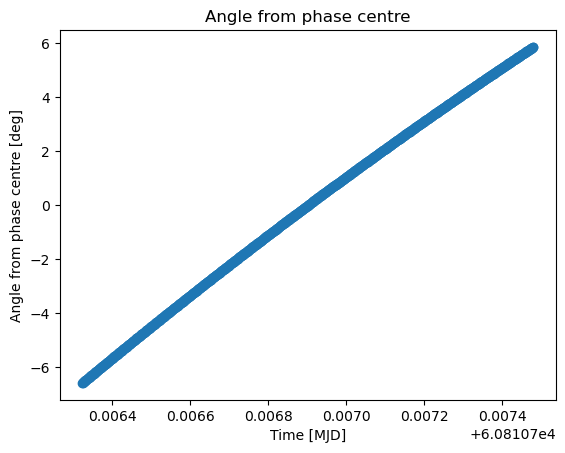

In [14]:
plt.title('Angle from phase centre')
offbeam=tel_pnt.separation(sat_coord)
offbeam[:np.argmin(offbeam)]*=-1
plt.scatter(mjds.flatten(),offbeam)
plt.xlabel('Time [MJD]')
plt.ylabel('Angle from phase centre [deg]')
plt.show()


### plot far field fringe ripples on the sky


In [15]:
pnt_xy = SkyCoord(tel_az[idx_t],tel_el[idx_t],unit=(u.deg,u.deg))

az=np.linspace(tel_az[idx_t]-5,tel_az[idx_t]+5,1000)
el=np.linspace(tel_el[idx_t]-5,tel_el[idx_t]+5,1000)
az,el=np.meshgrid(az,el)

ew_grid=pnt_xy.separation(SkyCoord(az,el,unit=(u.deg,u.deg)))
print(pnt,ew_grid.shape)

<SkyCoord (ICRS): (ra, dec) in deg
    (285.33091774, 43.09681959)> (1000, 1000)


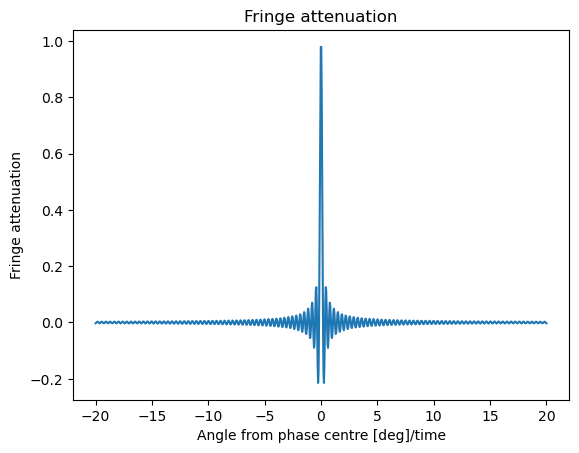

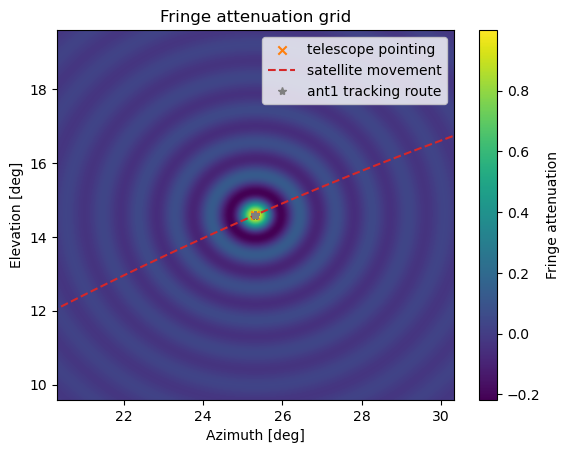

In [16]:
plt.title('Fringe attenuation')
fringe_attenuation=obs.fringe_attenuation(baseline=baselines[2]*u.m,theta=np.linspace(-20,20,1000)*u.deg,bandwidth=5*u.MHz)
plt.plot(np.linspace(-20,20,1000), fringe_attenuation)
plt.xlabel('Angle from phase centre [deg]/time')
plt.ylabel('Fringe attenuation')
plt.show()


# fringe_grid=ew_grid.value
fringe_grid=obs.fringe_attenuation(baseline=baselines[2]*u.m,theta=ew_grid,bandwidth=2*u.MHz)
plt.scatter(pnt_xy.ra.deg,pnt_xy.dec.deg,marker='x',label='telescope pointing',color='C1')
plt.plot(sat_az,sat_el,'--',color='C3',label='satellite movement')
plt.plot(tel_az,tel_el,'*',label='ant1 tracking route',color='C7')

plt.imshow(fringe_grid,origin='lower',extent=(az.min(),az.max(),el.min(),el.max()),aspect='auto')
plt.colorbar(label='Fringe attenuation')
plt.xlabel('Azimuth [deg]')
plt.ylabel('Elevation [deg]')
plt.title('Fringe attenuation grid')
plt.legend()
plt.savefig('satellite transit fringe far field attenuation.png')
plt.show()

### we now calculate the delays of the source in the baseline


##### we first calculate the tel_delay value is to account for the telescope delay offset at a certain direction
##### real_delay is the satellite's delay into the system during a farfield pointing observation 
##### we also calculate the actual satellite delays and the baseline delays

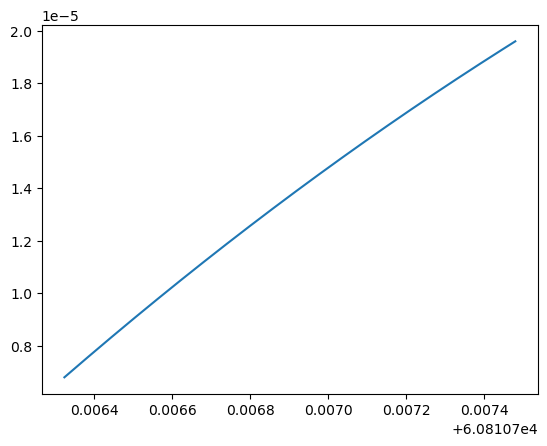

In [17]:
tel_delays=obs.mod_tau(az=tel_az,el=tel_el,lat=ant1.loc.lat,D=baselines[1]*u.m) ### baseline directional delay

satdelays=((sat_dist[0]*1000/3e8)-(sat_dist[1]*1000/3e8))*u.s ### satellite signal delay between two elements
satdelays=satdelays.flatten()

### calculate the remaining satellite delay that appears in the system
real_delays=obs.baseline_nearfield_delay(
                                         l1=sat_dist[0]*u.km,l2=sat_dist[2]*u.km,tau=tel_delays).flatten()
delays=satdelays-tel_delays
# real_delays=real_delays.reshape(len(baselines),-1)


plt.plot(mjds.flatten(),real_delays)
### sanity check of your delay calculations
# plt.plot(mjds.flatten(),tel_delays)
# plt.plot(mjds.flatten(),real_delays-satdelays) ### this should be same as tel_delays
plt.show()

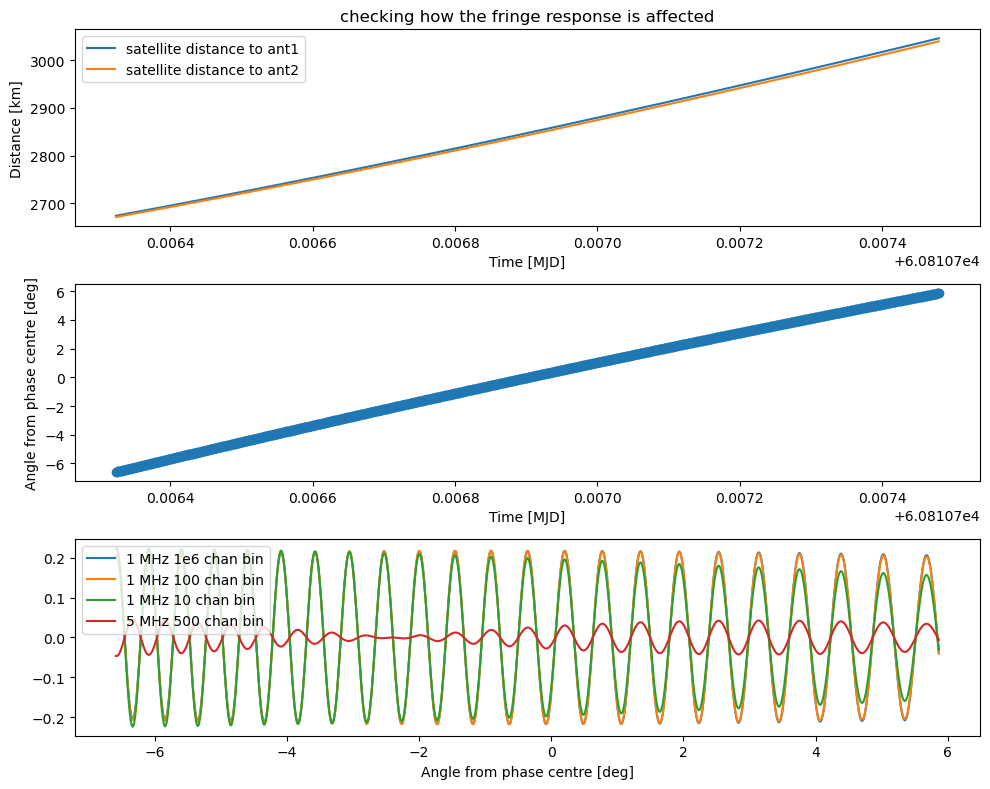

In [18]:
plt.figure(figsize=(10, 8))


ax1=plt.subplot(311)
ax1.set_title('checking how the fringe response is affected')

ax1.plot(mjds.flatten(),sat_dist[0].flatten(),label='satellite distance to ant1')
ax1.plot(mjds.flatten(),sat_dist[2].flatten(),label='satellite distance to ant2')
ax1.legend()
ax1.set_xlabel('Time [MJD]')
# ax1.set_ylabel('Fringe response')
ax1.set_ylabel('Distance [km]')
ax2=plt.subplot(312)
plt.scatter(mjds.flatten(),offbeam)
ax2.set_xlabel('Time [MJD]')
ax2.set_ylabel('Angle from phase centre [deg]')
ax3=plt.subplot(313)
ax3.plot(offbeam,obs.bw_fringe(delays=satdelays,bwchan=1*u.MHz,fch1=100*u.MHz,chan_bin=100000),label='1 MHz 1e6 chan bin')
ax3.plot(offbeam,obs.bw_fringe(delays=satdelays,bwchan=1*u.MHz,fch1=100*u.MHz,chan_bin=100),label='1 MHz 100 chan bin')
ax3.plot(offbeam,obs.bw_fringe(delays=satdelays,bwchan=1*u.MHz,fch1=100*u.MHz,chan_bin=10),label='1 MHz 10 chan bin')
ax3.plot(offbeam,obs.bw_fringe(delays=satdelays,bwchan=5*u.MHz,fch1=100*u.MHz,chan_bin=500),label='5 MHz 500 chan bin')
# ax3.plot(offbeam,obs.bw_fringe(delays=satdelays,bwchan=5*u.MHz,fch1=100*u.MHz,chan_bin=100),label='5 MHz 100 chan bin')

ax3.set_xlabel('Angle from phase centre [deg]')
plt.legend()
plt.tight_layout()
plt.savefig('fringe shift example.png')
plt.show()

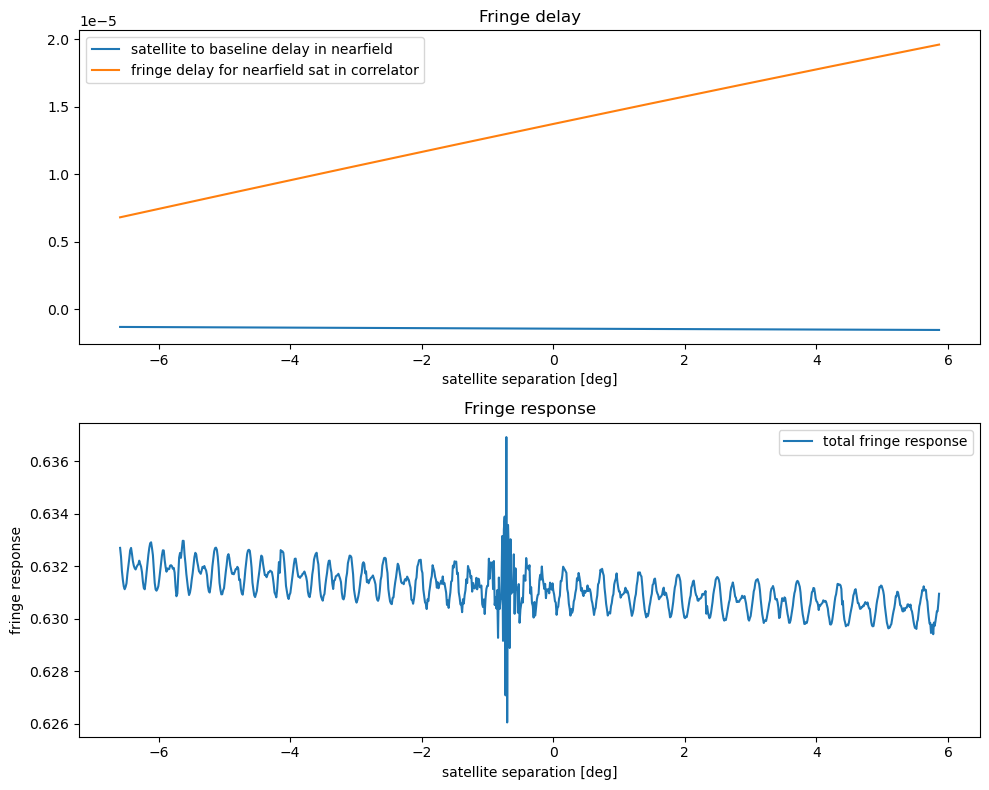

In [19]:

plt.figure(figsize=(10, 8))
ax1=plt.subplot(211)
ax1.plot(offbeam, satdelays,label='satellite to baseline delay in nearfield')
# ax1.plot(mjds.flatten(),obs.tdelay(rab,ew_alt),label='correlator delay for sky fringe attenuation')
# ax1.plot(mjds.flatten(), obs.tdelay(rab,ew_alt)-satdelays,label='fringe delay for nearfield sat in correlator')
ax1.plot(offbeam, real_delays,label='fringe delay for nearfield sat in correlator')
ax1.set_xlabel('Time [MJD]')
ax1.set_xlabel('satellite separation [deg]')

# ax1.set_ylabel('Fringe delay [s]')
ax1.set_title('Fringe delay')
# ax1.set_xlim(-40,-30)
ax1.legend()

# bwfringe = np.sum([obs.fringe_response(delay=real_delays-obs.tdelay(rab,tel2_pnt.alt),frequency=i*u\.Hz) for i in np.arange(10.7e9,10.95e9,1e6)],axis=0)
ax2=plt.subplot(212,sharex=ax1)
powerfringe=np.zeros(len(mjds.flatten())) ### this will collect the power
# bands=np.arange(10.7e3,12.1e3,250)
bands=np.arange(100,150,0.050)*u.MHz
for fch1 in bands:
    bwfringe=obs.bw_fringe(delays=satdelays,bwchan=50*u.kHz,fch1=fch1,chan_bin=100)
    powerfringe+=np.abs(bwfringe) ### consider equal power is equal
    # ax2.plot(offbeam, (bwfringe),label=f'{fch1}')
ax2.plot(offbeam, powerfringe/len(bands),label='total fringe response')
# ax2.set_xlabel('Time [MJD]')
ax2.set_xlabel('satellite separation [deg]')

ax2.set_ylabel('fringe response')
ax2.set_title('Fringe response')
ax2.legend()


plt.tight_layout()
plt.show()

In [20]:
plt.close()
star_el=test.topo_pos_el
print(star_el.shape)
### get power from satellite
satpwrpfd=(np.interp(star_el,xp=x_el,fp=y_pfd))  ###
print(satpwrpfd.shape)

(3, 1, 1, 1, 1000, 32)
(3, 1, 1, 1, 1000, 32)


In [40]:
ang_sep,delta_az,delta_el=obs.sat_frame_pointing(test.satf_az,test.satf_el,beam_el=tel_el[idx_t],beam_az=tel_az[idx_t])
# ang_sep=test.txbeam_angsep(beam_az=20,beam_el=0)
print(ang_sep.shape)

(3, 1, 1, 1, 1000, 32)


In [41]:
test.create_baselines() ### create baselines within object
# print(test.baselines) ### show baseline combinatiosn mask
# print(test.bearing_D,test.bearings) ### show baseline combinations

(3, 1, 1000, 1, 1000, 32)
(3, 1000, 32)


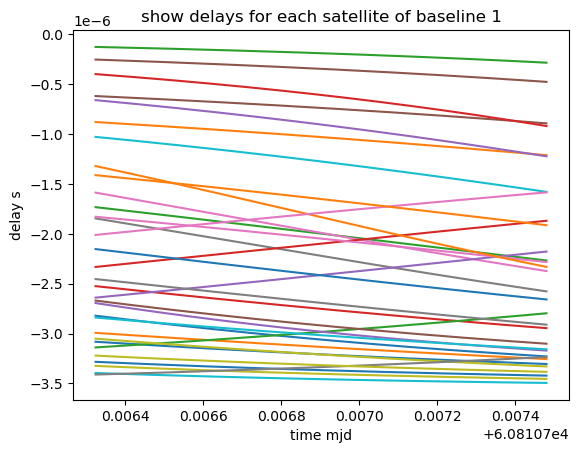

In [42]:
baseline_delays=test.baselines_nearfield_delays()
print(baseline_delays.shape)
# 

delays=baseline_delays[:,:,idx_t,:,:,:].reshape(3,len(test.pnt),-1)
print(delays.shape)
plt.title('show delays for each satellite of baseline 1')
plt.plot(mjds.flatten(),delays[1])
plt.xlabel('time mjd')
plt.ylabel('delay s')
plt.show()

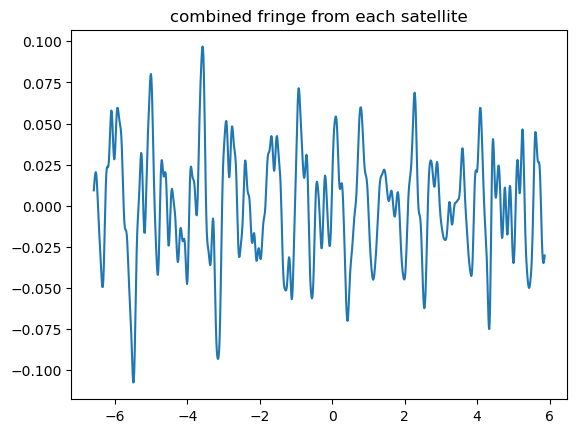

In [43]:
### a example of the combined fringe signal from all satellites
fringes=obs.bw_fringe(delays=delays[1].flatten(),bwchan=1*u.MHz,fch1=100*u.MHz)
# print(fringes)
# fringes[np.where(fringes==0)]=1e-12
plt.title('combined fringe from each satellite')
plt.plot(offbeam,fringes.reshape(1000,-1).mean(1))

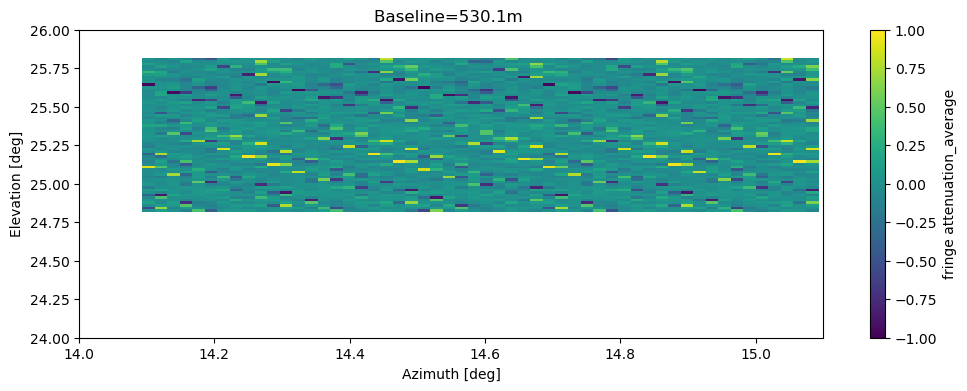

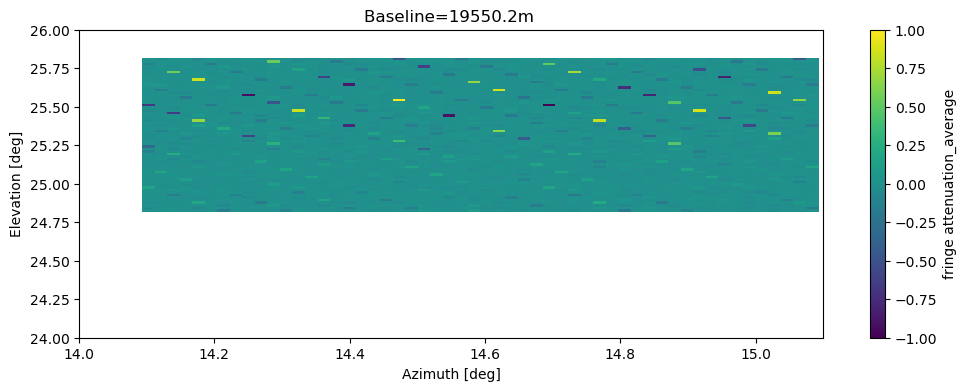

In [45]:
for i in range(test.baseline_delays.shape[0]-1):
    fringes=obs.bw_fringe(delays=delays[i+1].flatten(),bwchan=1*u.MHz,fch1=100*u.MHz).reshape(delays[i+1].shape)
    skynet.plotgrid(fringes.flatten(),grid_info=test.grid_info,elmin=24,elmax=26,
                    zlabel='fringe attenuation_average',
                    azmin=14,azmax=15.1,vmin=-1,vmax=1)
    plt.title(f"Baseline={np.round(test.bearing_D.flatten()[i+1],1)}m ")
    plt.show()
    plt.close()
    